In [31]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from math import floor
from scipy.stats import gaussian_kde

from utility.types import RegimeDetectionModels
from data.universe import Universe
from data.benchmark import Benchmark
from portfolio_management.market_regime import detect_market_regime
from portfolio_management.beta_estimation import (
    estimate_dynamic_beta_and_alpha,
    historical_rolling_beta,
)

# Data loading


In [32]:
bench = Benchmark()
benchmark = bench.get_benchmark_returns_data()
benchmark, bench.benchmark_perf

(             OISESTR       SPX      SX5T
 Date                                    
 2019-10-01 -0.000022  0.000000  0.000000
 2019-10-02 -0.000022 -0.017903 -0.029827
 2019-10-03 -0.000022  0.007972  0.001189
 2019-10-04 -0.000022  0.014217  0.008586
 2019-10-07 -0.000022 -0.004478  0.007117
 ...              ...       ...       ...
 2024-02-09  0.000155  0.000000  0.000000
 2024-02-12  0.000155  0.004788  0.007551
 2024-02-13  0.000155 -0.013674 -0.012024
 2024-02-14  0.000155  0.009580  0.004252
 2024-02-15  0.000155  0.005821  0.007209
 
 [1143 rows x 3 columns],
 Date
 2019-10-01    0.999993
 2019-10-02    0.981493
 2019-10-03    0.983629
 2019-10-04    0.990607
 2019-10-07    0.993187
                 ...   
 2024-02-09    1.323521
 2024-02-12    1.329863
 2024-02-13    1.318233
 2024-02-14    1.323629
 2024-02-15    1.330020
 Freq: B, Name: benchmark_perf, Length: 1143, dtype: float64)

In [33]:
universe = Universe()
universe_data = universe.get_universe_price()
universe_data

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX
date,,,,,
2016-06-01,100.166,107.00,119.94,45.205,32.067
2016-06-02,100.165,107.52,120.47,45.225,32.182
2016-06-03,100.165,106.42,119.83,44.805,31.623
2016-06-06,100.163,106.28,121.56,44.950,31.803
2016-06-07,100.163,106.98,122.23,45.445,31.976
...,...,...,...,...,...
2024-02-22,100.855,162.56,224.96,78.040,91.141
2024-02-23,100.867,163.28,224.96,78.580,91.525
2024-02-26,100.898,162.71,223.95,78.250,91.150


In [34]:
universe_data = pd.merge(
    universe_data, bench.benchmark_perf, left_index=True, right_index=True
)
universe_data

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX,benchmark_perf
2019-10-01,98.847,114.19,140.63,54.79,49.255,0.999993
2019-10-02,98.845,111.17,137.88,53.09,47.873,0.981493
2019-10-03,98.844,110.97,138.82,53.22,47.806,0.983629
2019-10-04,98.843,111.87,139.99,53.74,48.651,0.990607
2019-10-07,98.838,112.29,139.11,54.04,48.880,0.993187
...,...,...,...,...,...,...
2024-02-09,100.715,157.31,220.69,75.46,90.260,1.323521
2024-02-12,100.747,158.32,224.12,75.89,91.051,1.329863
2024-02-13,100.758,157.20,219.71,75.23,90.120,1.318233
2024-02-14,100.769,158.78,221.76,75.77,90.134,1.323629


# Regime detection


In [35]:
REGIMES = detect_market_regime(
    market_data=universe_data[["benchmark_perf"]].pct_change().fillna(0).to_numpy(),
    market_regime_detection_algorithm=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    scale_data=True,
    scaler_type="robust",
)
universe_data["REGIMES"] = REGIMES
universe_data

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX,benchmark_perf,REGIMES
2019-10-01,98.847,114.19,140.63,54.79,49.255,0.999993,1
2019-10-02,98.845,111.17,137.88,53.09,47.873,0.981493,1
2019-10-03,98.844,110.97,138.82,53.22,47.806,0.983629,0
2019-10-04,98.843,111.87,139.99,53.74,48.651,0.990607,0
2019-10-07,98.838,112.29,139.11,54.04,48.880,0.993187,0
...,...,...,...,...,...,...,...
2024-02-09,100.715,157.31,220.69,75.46,90.260,1.323521,0
2024-02-12,100.747,158.32,224.12,75.89,91.051,1.329863,0
2024-02-13,100.758,157.20,219.71,75.23,90.120,1.318233,0
2024-02-14,100.769,158.78,221.76,75.77,90.134,1.323629,0


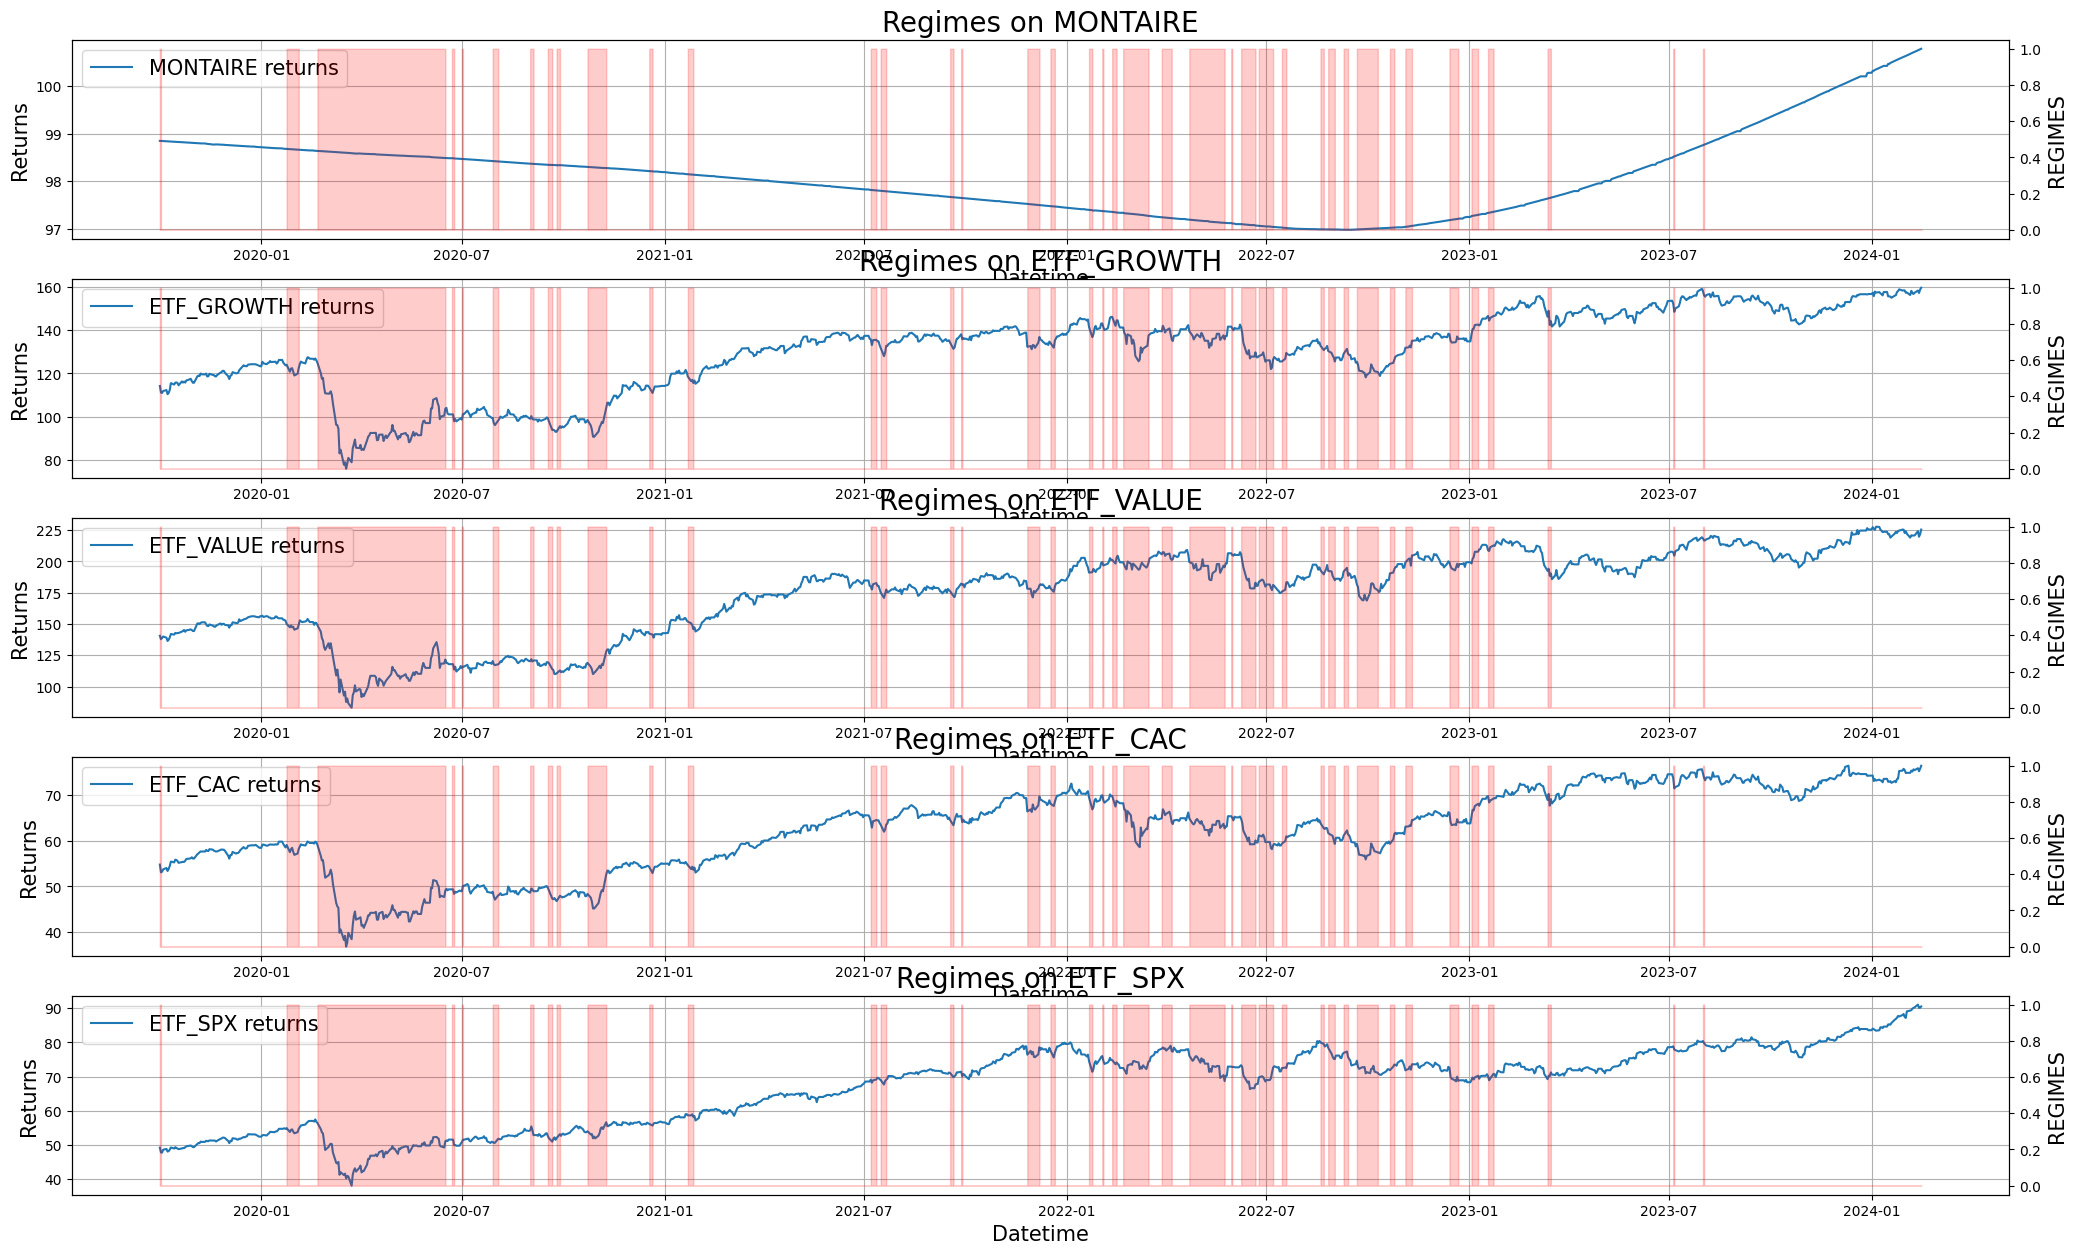

In [36]:
fig, ax = plt.subplots(5, 1, figsize=(25, 15))
for i, sec in enumerate(["MONTAIRE", "ETF_GROWTH", "ETF_VALUE", "ETF_CAC", "ETF_SPX"]):
    ax_l = ax[i].twinx()
    ax_l.fill_between(
        universe_data.index,
        universe_data["REGIMES"],
        alpha=0.2,
        color="red",
        step="pre",
    )
    ax[i].plot(universe_data[sec], label=f"{sec} returns")
    ax[i].set_xlabel("Datetime", fontsize=15)
    ax[i].set_ylabel("Returns", fontsize=15)
    ax_l.set_ylabel("REGIMES", fontsize=15)
    ax[i].set_title(f"Regimes on {sec}", fontsize=20)
    ax[i].grid()
    ax[i].legend(fontsize=15)

# Dynamic beta estimation


In [37]:
BETA_TO_OBSERVE = "ETF_VALUE"

In [38]:
estimated_alpha, estimated_beta = estimate_dynamic_beta_and_alpha(
    universe_data["benchmark_perf"].pct_change().fillna(0).to_numpy(),
    universe_data[BETA_TO_OBSERVE].pct_change().fillna(0).to_numpy(),
)

historical_OLS_beta = historical_rolling_beta(
    universe_data["benchmark_perf"].pct_change().fillna(0).to_numpy(),
    universe_data[BETA_TO_OBSERVE].pct_change().fillna(0).to_numpy(),
    50,
)

In [39]:
universe_data["BETA_GROWTH_ETF_TO_BENCH"] = estimated_beta

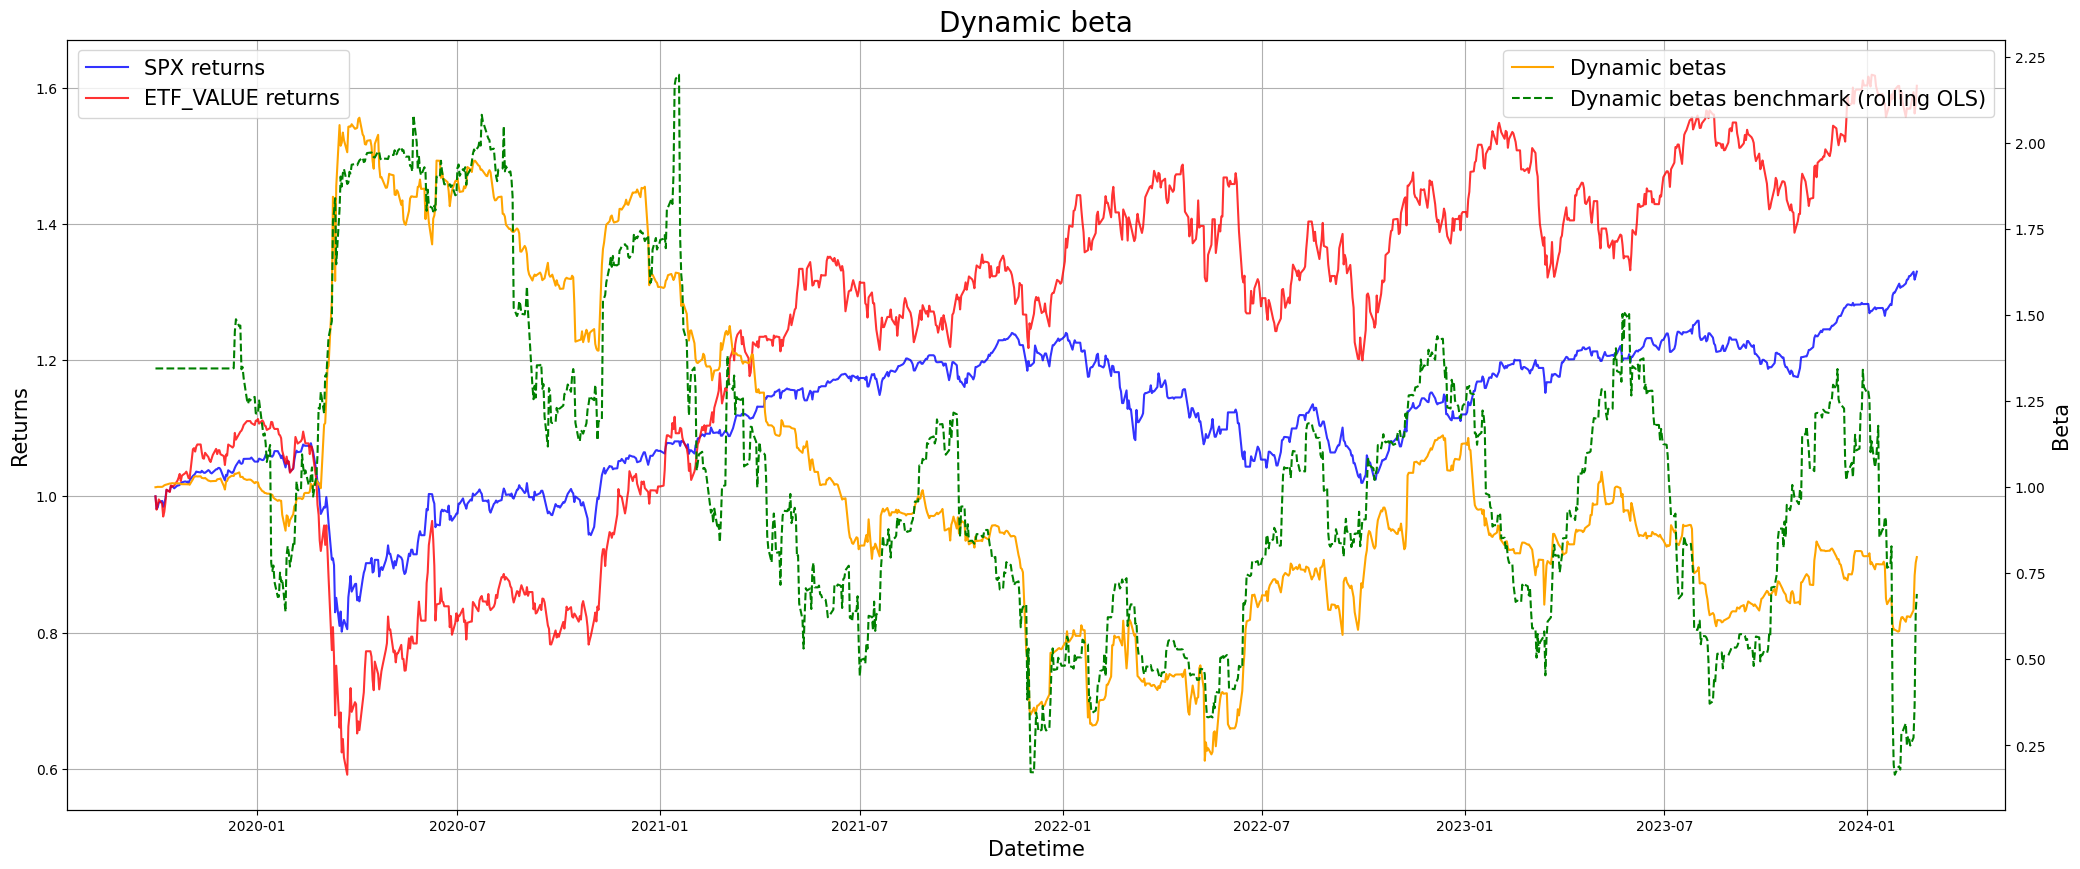

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
ax_l = ax.twinx()
ax_l.plot(
    universe_data["BETA_GROWTH_ETF_TO_BENCH"],
    label="Dynamic betas",
    color="orange",
)
ax_l.plot(
    universe_data.index,
    historical_OLS_beta,
    label="Dynamic betas benchmark (rolling OLS)",
    color="green",
    linestyle="--",
)

ax_l.legend(loc="upper right", fontsize=15)
ax.plot(
    (universe_data["benchmark_perf"].pct_change().fillna(0) + 1).cumprod(),
    label="SPX returns",
    color="blue",
    alpha=0.8,
)
ax.plot(
    (universe_data[BETA_TO_OBSERVE].pct_change().fillna(0) + 1).cumprod(),
    label=f"{BETA_TO_OBSERVE} returns",
    color="red",
    alpha=0.8,
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Returns", fontsize=15)
ax_l.set_ylabel("Beta", fontsize=15)
ax.set_title("Dynamic beta", fontsize=20)
# ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=15)

# Beta analysis among regime


In [11]:
universe_data_returns = universe_data.copy()
for col in [
    "MONTAIRE",
    "ETF_GROWTH",
    "ETF_VALUE",
    "ETF_CAC",
    "ETF_SPX",
    "benchmark_perf",
]:
    universe_data_returns[col] = universe_data_returns[col].pct_change().fillna(0)

universe_data_returns

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX,benchmark_perf,REGIMES,BETA_GROWTH_ETF_TO_BENCH
2019-10-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1.000000
2019-10-02,-0.000020,-0.026447,-0.019555,-0.031028,-0.028058,-0.018501,1,1.000358
2019-10-03,-0.000010,-0.001799,0.006818,0.002449,-0.001400,0.002177,0,1.001210
2019-10-04,-0.000010,0.008110,0.008428,0.009771,0.017676,0.007094,0,1.000975
2019-10-07,-0.000051,0.003754,-0.006286,0.005582,0.004707,0.002605,0,1.001104
...,...,...,...,...,...,...,...,...
2024-02-09,0.000099,0.003637,-0.000091,-0.002512,0.001854,0.000046,0,0.622348
2024-02-12,0.000318,0.006420,0.015542,0.005698,0.008764,0.004792,0,0.642508
2024-02-13,0.000109,-0.007074,-0.019677,-0.008697,-0.010225,-0.008745,0,0.743866
2024-02-14,0.000109,0.010051,0.009330,0.007178,0.000155,0.004094,0,0.780661


In [12]:
universe_data_returns.groupby(by=["REGIMES"]).mean()

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX,benchmark_perf,BETA_GROWTH_ETF_TO_BENCH
REGIMES,,,,,,,
0,0.000026,0.001033,0.001072,0.000992,0.001198,0.000756,0.993583
1,-0.000015,-0.001943,-0.001256,-0.001804,-0.001542,-0.001387,1.122758


In [13]:
universe_data_returns

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX,benchmark_perf,REGIMES,BETA_GROWTH_ETF_TO_BENCH
2019-10-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1.000000
2019-10-02,-0.000020,-0.026447,-0.019555,-0.031028,-0.028058,-0.018501,1,1.000358
2019-10-03,-0.000010,-0.001799,0.006818,0.002449,-0.001400,0.002177,0,1.001210
2019-10-04,-0.000010,0.008110,0.008428,0.009771,0.017676,0.007094,0,1.000975
2019-10-07,-0.000051,0.003754,-0.006286,0.005582,0.004707,0.002605,0,1.001104
...,...,...,...,...,...,...,...,...
2024-02-09,0.000099,0.003637,-0.000091,-0.002512,0.001854,0.000046,0,0.622348
2024-02-12,0.000318,0.006420,0.015542,0.005698,0.008764,0.004792,0,0.642508
2024-02-13,0.000109,-0.007074,-0.019677,-0.008697,-0.010225,-0.008745,0,0.743866
2024-02-14,0.000109,0.010051,0.009330,0.007178,0.000155,0.004094,0,0.780661


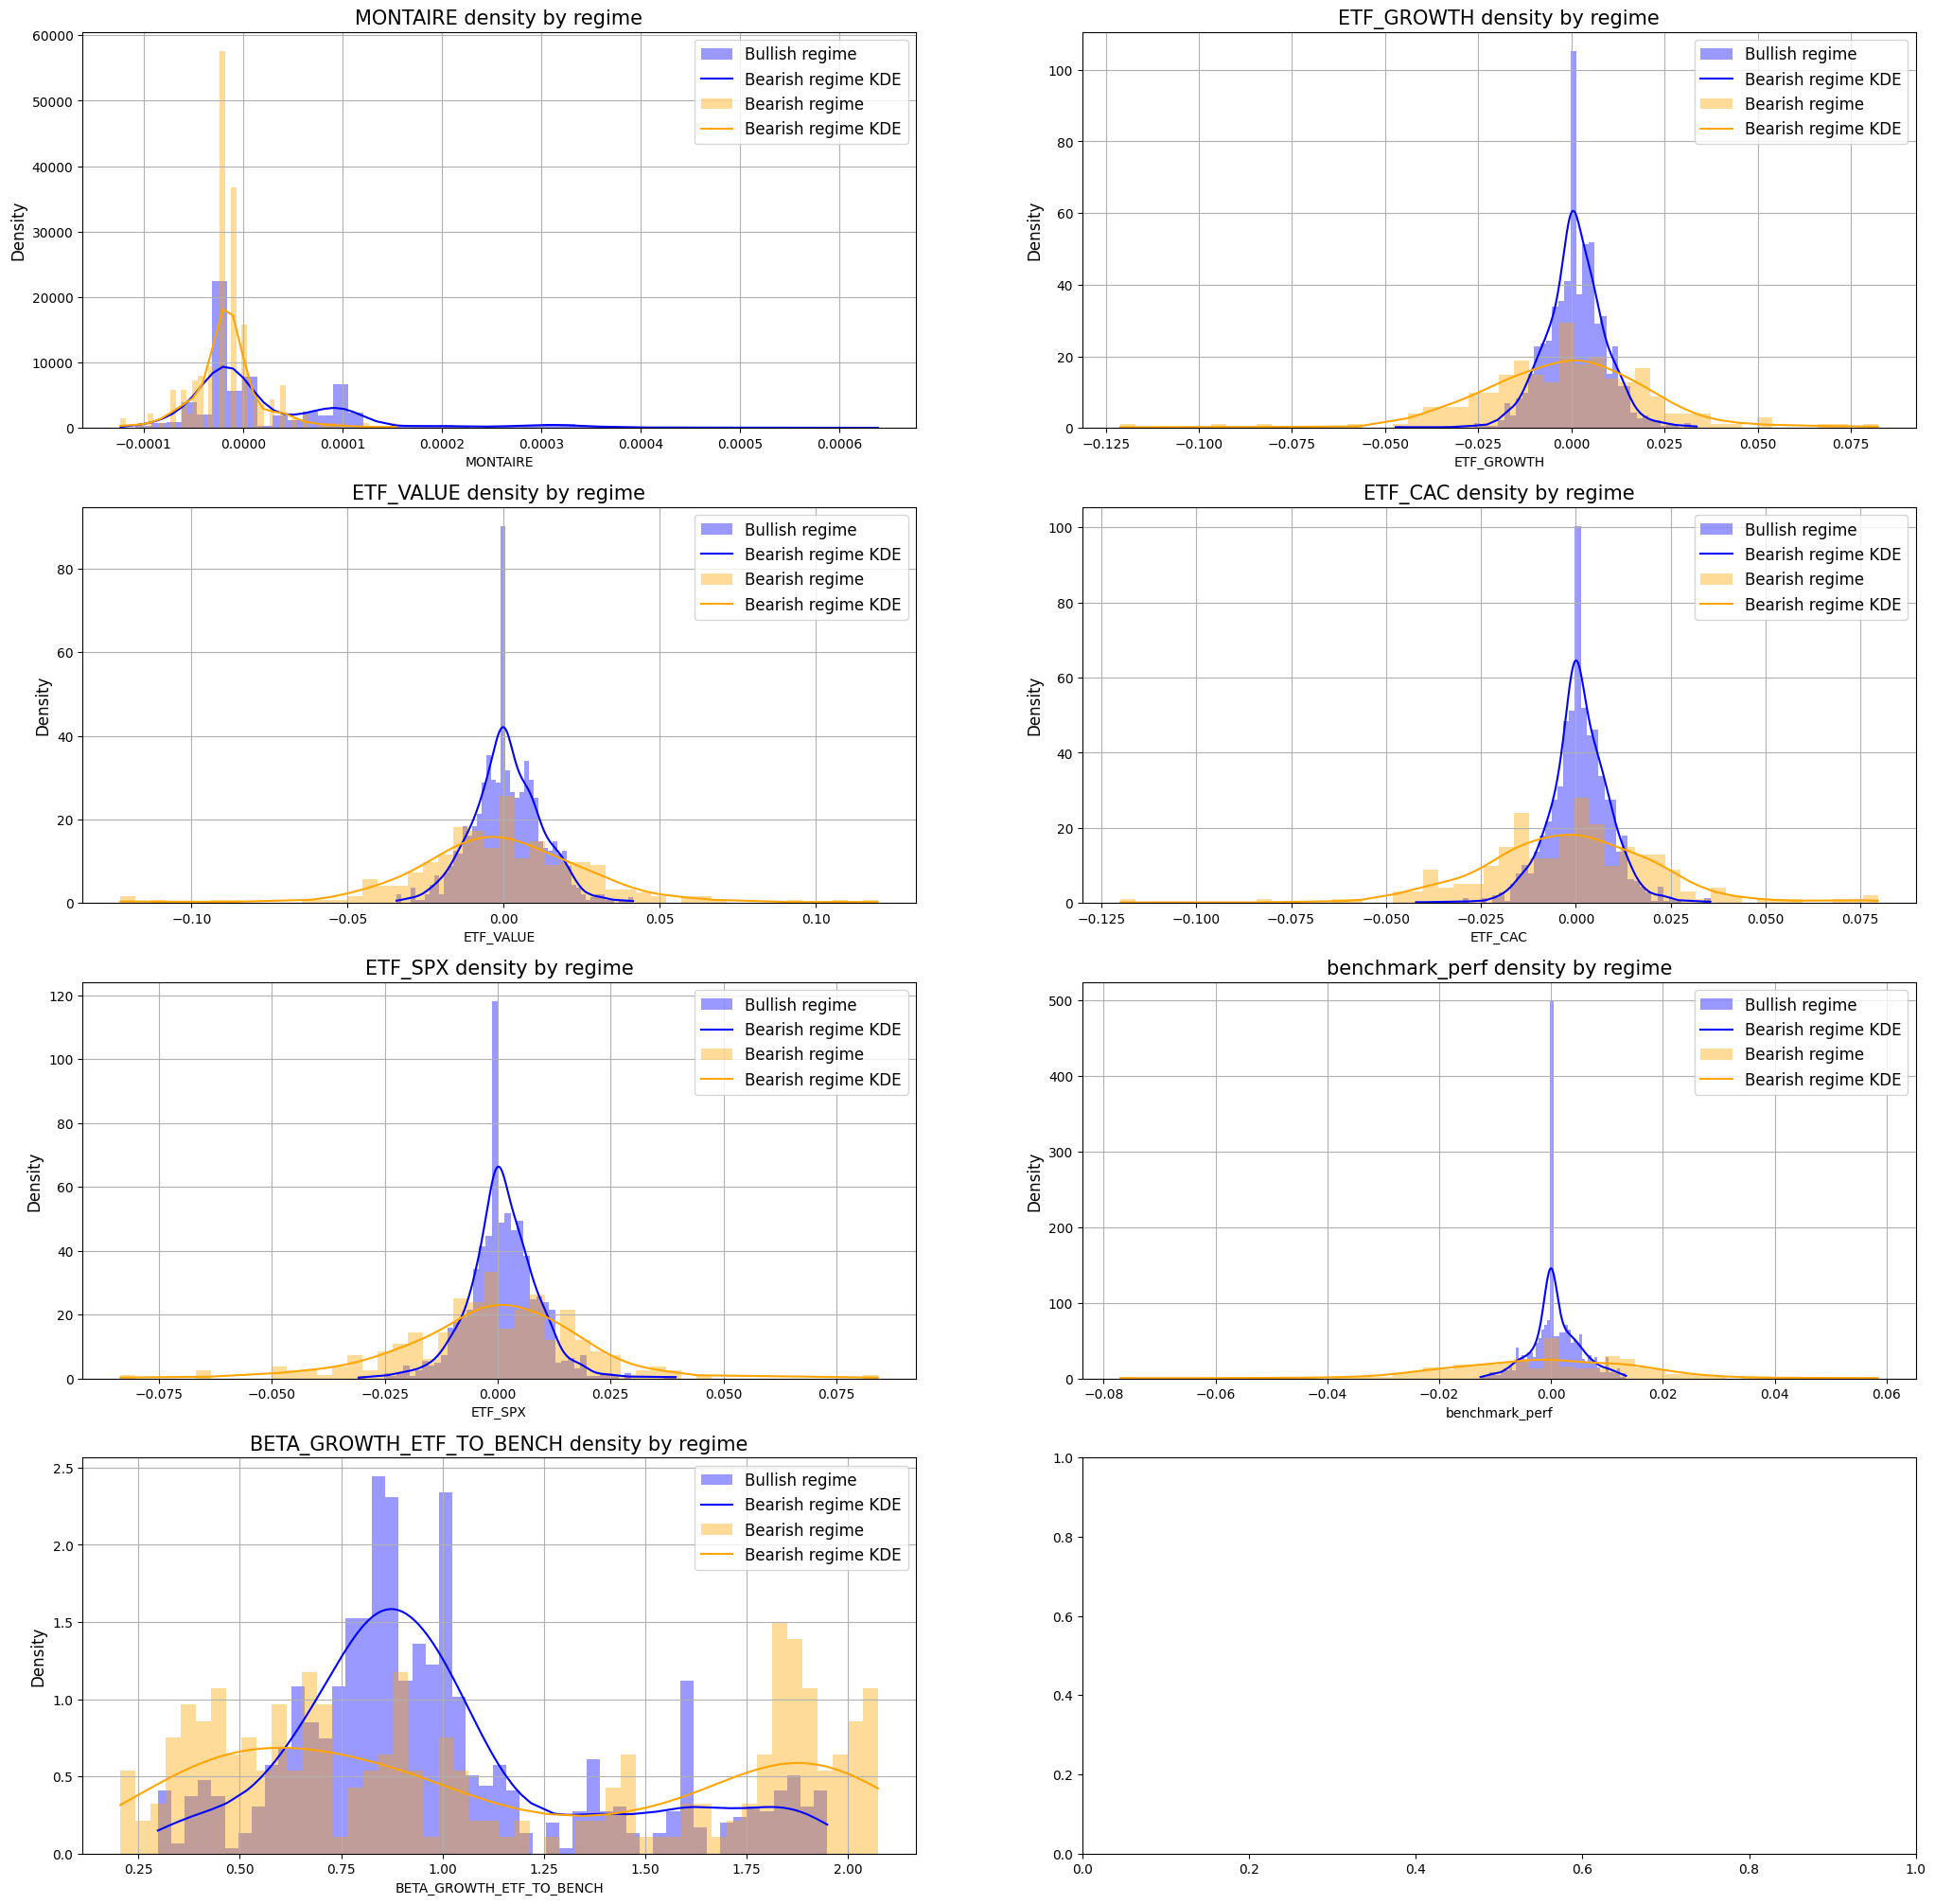

In [15]:

fig, ax = plt.subplots(
    round(
        universe_data_returns.drop(columns=["REGIMES"]).columns.shape[0]
        / 2
    ),
    2,
    figsize=(25, 25),
)
k = 0
for i, sec in enumerate(universe_data_returns.drop(columns=["REGIMES"]).columns):
    samples_1 = sorted(
        universe_data_returns[universe_data_returns["REGIMES"] == 1][sec].to_numpy()
    )
    samples_0 = sorted(
        universe_data_returns[universe_data_returns["REGIMES"] == 0][sec].to_numpy()
    )
    if i % 2 != 0 :
        c = 1
    else:
        c = 0

    ax[floor(i/2), c].hist(
        samples_0,
        bins=50,
        density=True,
        alpha=0.4,
        color="blue",
        label="Bullish regime",
    )
    ax[floor(i/2), c].plot(
        samples_0,
        gaussian_kde(samples_0, bw_method="scott").pdf(samples_0),
        color="blue",
        label="Bearish regime KDE",
    )
    ax[floor(i/2), c].hist(
        samples_1,
        bins=50,
        density=True,
        alpha=0.4,
        color="orange",
        label="Bearish regime",
    )
    ax[floor(i/2), c].plot(
        samples_1,
        gaussian_kde(samples_1, bw_method="scott").pdf(samples_1),
        color="orange",
        label="Bearish regime KDE",
    )

    ax[floor(i/2), c].set_xlabel(f"{sec}", fontsize=10)
    ax[floor(i/2), c].set_ylabel("Density", fontsize=12)
    ax[floor(i/2), c].set_title(f"{sec} density by regime", fontsize=15)
    ax[floor(i/2), c].grid()
    ax[floor(i/2), c].legend(fontsize=12)


# Beta regime


In [16]:
universe_data

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX,benchmark_perf,REGIMES,BETA_GROWTH_ETF_TO_BENCH
2019-10-01,98.847,114.19,140.63,54.79,49.255,0.999993,1,1.000000
2019-10-02,98.845,111.17,137.88,53.09,47.873,0.981493,1,1.000358
2019-10-03,98.844,110.97,138.82,53.22,47.806,0.983629,0,1.001210
2019-10-04,98.843,111.87,139.99,53.74,48.651,0.990607,0,1.000975
2019-10-07,98.838,112.29,139.11,54.04,48.880,0.993187,0,1.001104
...,...,...,...,...,...,...,...,...
2024-02-09,100.715,157.31,220.69,75.46,90.260,1.323521,0,0.622348
2024-02-12,100.747,158.32,224.12,75.89,91.051,1.329863,0,0.642508
2024-02-13,100.758,157.20,219.71,75.23,90.120,1.318233,0,0.743866
2024-02-14,100.769,158.78,221.76,75.77,90.134,1.323629,0,0.780661


In [17]:
universe_data["BETA_REGIMES"] = detect_market_regime(
    market_data=universe_data[["BETA_GROWTH_ETF_TO_BENCH"]]
    .fillna(0)
    .to_numpy(),
    market_regime_detection_algorithm=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    scale_data=True,
    scaler_type="robust",
)

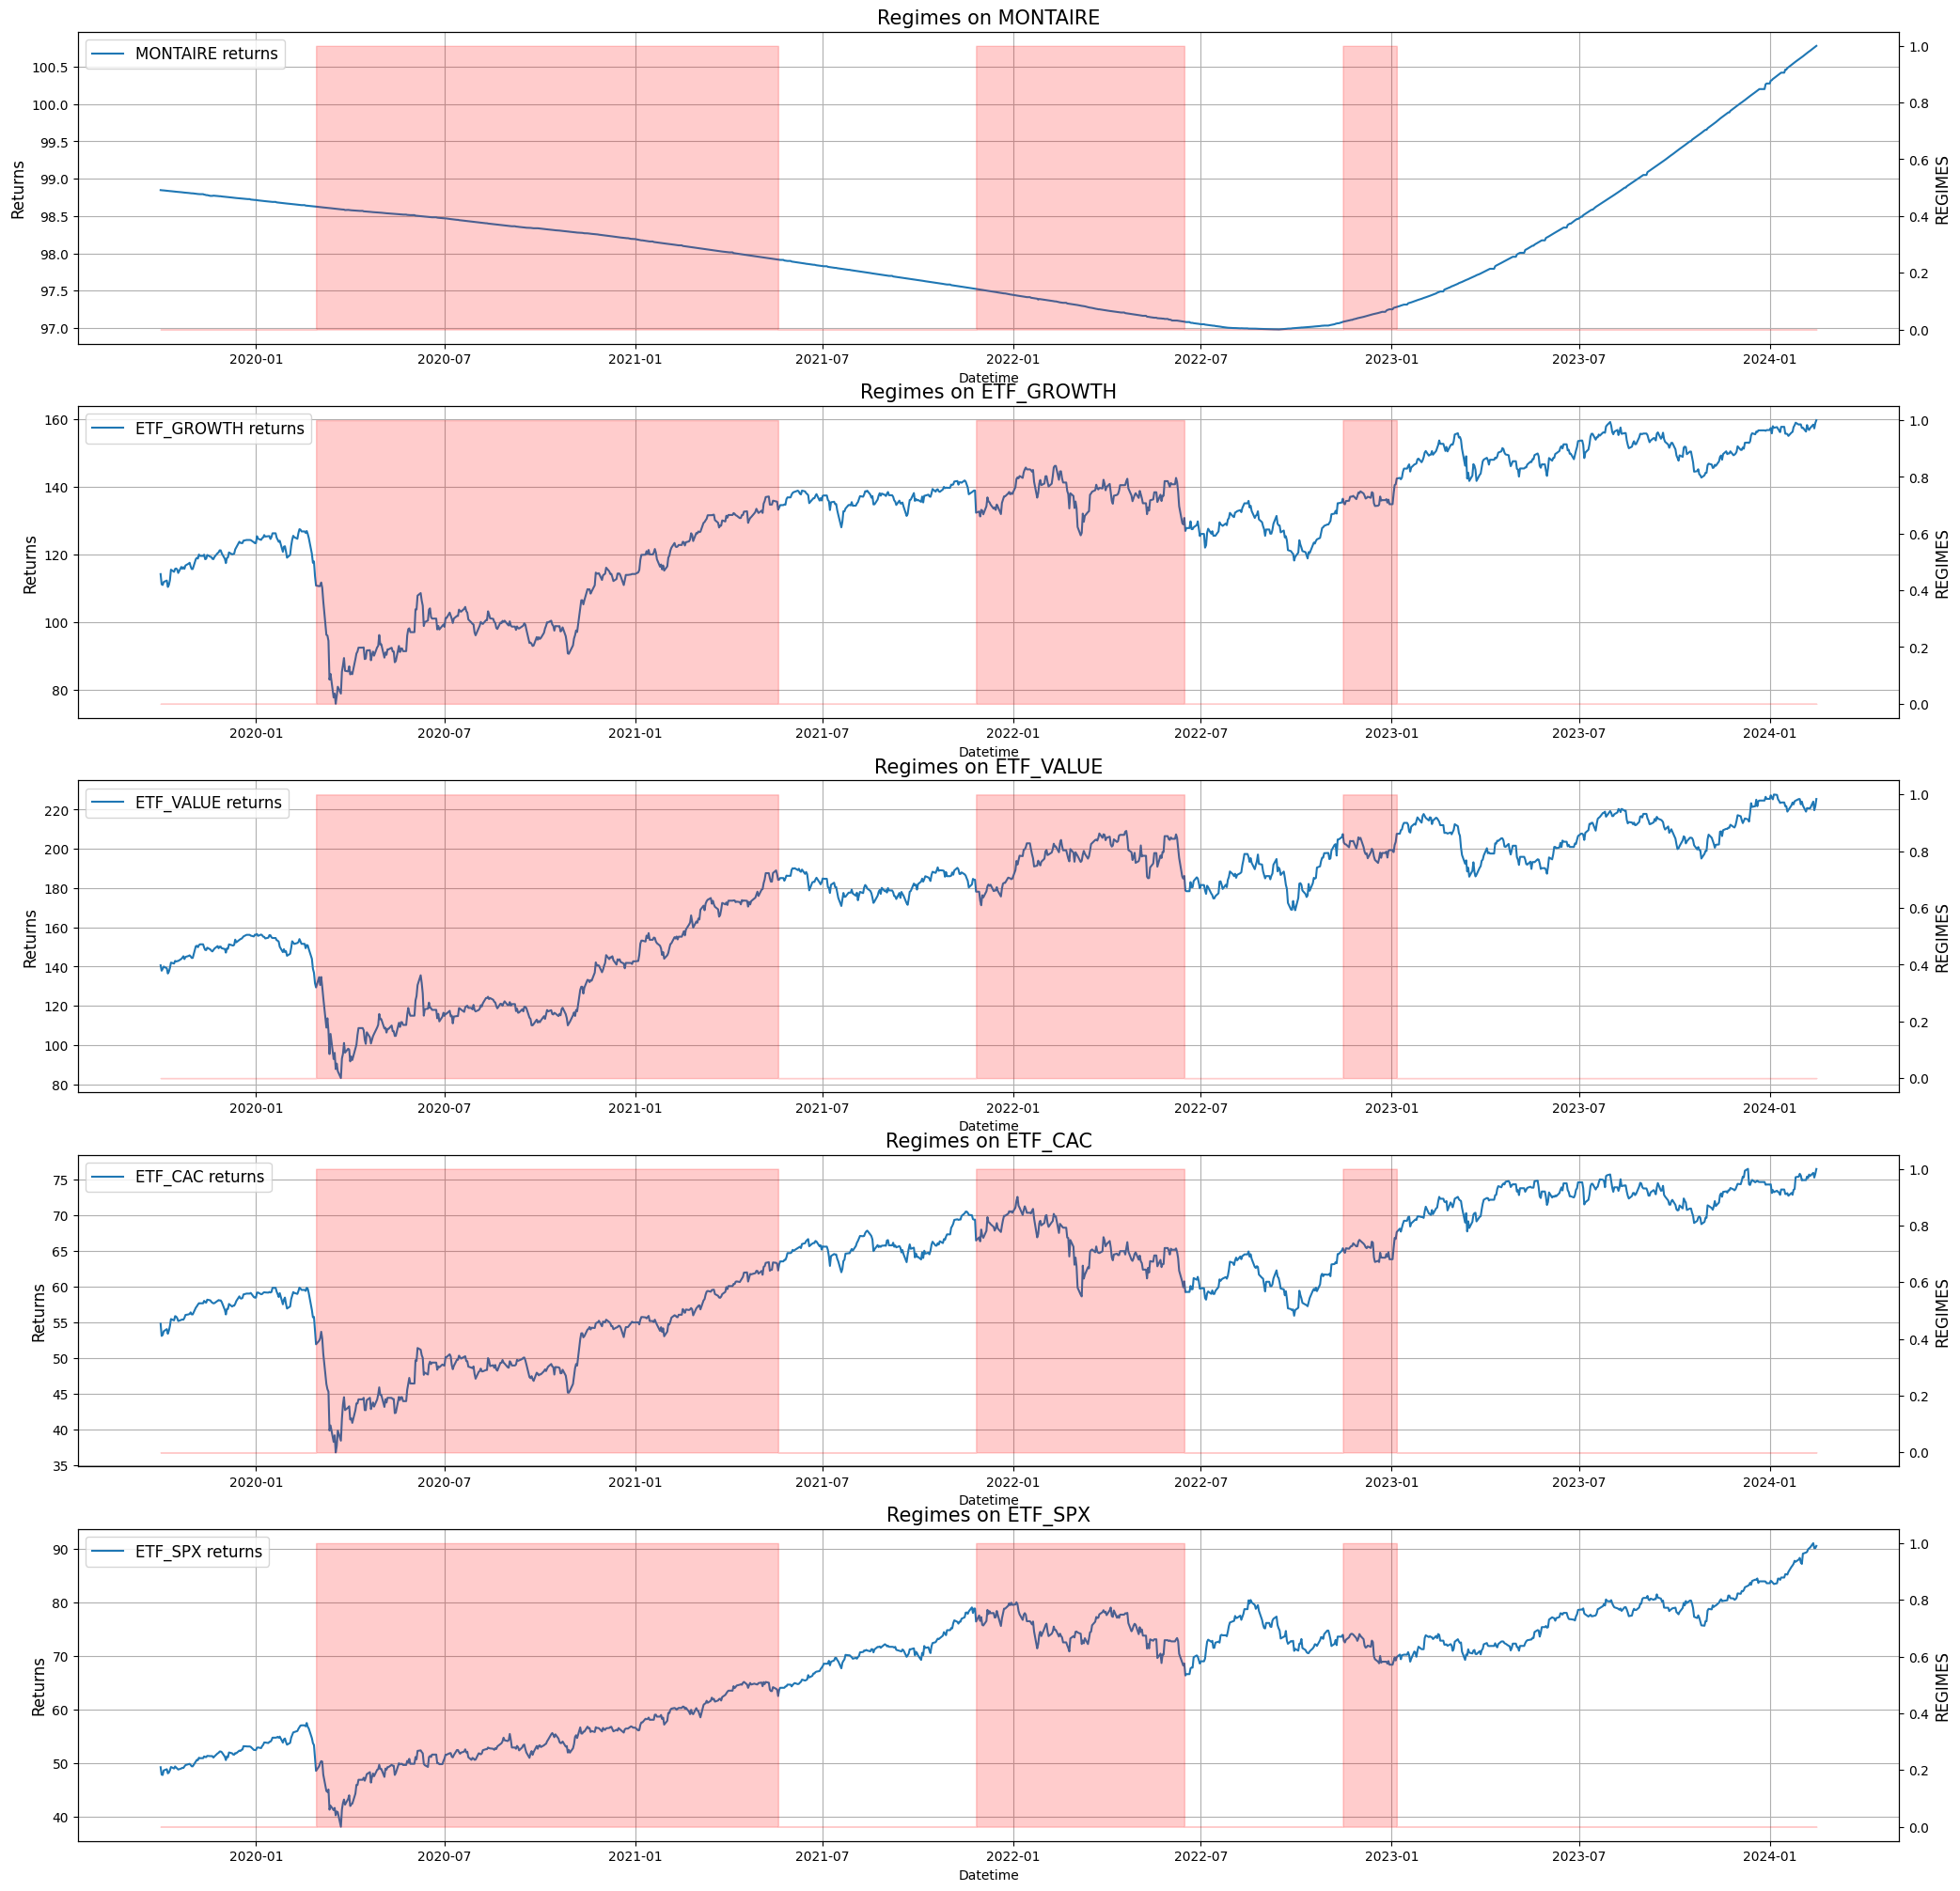

In [18]:
fig, ax = plt.subplots(5, 1, figsize=(25, 25))
for i, sec in enumerate(["MONTAIRE", "ETF_GROWTH", "ETF_VALUE", "ETF_CAC", "ETF_SPX"]):
    ax_l = ax[i].twinx()
    ax_l.fill_between(
        universe_data.index,
        universe_data["BETA_REGIMES"],
        alpha=0.2,
        color="red",
        step="pre",
    )
    ax[i].plot(universe_data[sec], label=f"{sec} returns")
    ax[i].set_xlabel("Datetime", fontsize=10)
    ax[i].set_ylabel("Returns", fontsize=12)
    ax_l.set_ylabel("REGIMES", fontsize=12)
    ax[i].set_title(f"Regimes on {sec}", fontsize=15)
    ax[i].grid()
    ax[i].legend(fontsize=12)